# Train DNN


## Who is Running?

In [1]:
#Matheus  
project_root = "/content/drive/MyDrive/Mestrado/Deep Learning/Projeto/Projeto_Final_DL"
#Gabi
#Jean
#Sandra

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## General Parâmeters

In [2]:
# Geneal parameters used on this notebook
study_case_name = "Pulsatrix_koeniswaldiana" #@param {type:"string"}
only_focus = True #@param {type:"boolean"}
strategy = "Flatten_DNN" #@param ["Flatten_DNN", "TabNet"]{type:"string"}

# Neural Networks Hparams
batch_size = 10 #@param {type:"integer"}
num_classes = 2 #@param {type:"integer"}
epochs = 125 #@param {type:"integer"}

Fixed Parameters

In [3]:
# Geneal parameters used on this notebook
study_cases_root_folder = project_root+"/Data/Study_Cases"
presence_absence_folder_path  = project_root+ "/Data/Species_Presence_Absence"
model_weights_folder_path = project_root + "/Data/Model_Weights"
env_info_path = project_root+ "/Data/Species_Enverionment_Info"
base_txt_files_path = project_root + "/Data/Standarized_Brazil_Data/TXT_Aux_Files"
base_csv_files_path = project_root + "/Data/Standarized_Brazil_Data/CSV_Aux_Files"
mean_std_path = f"{base_csv_files_path}/brazil_vars_mean_std.csv" 


## Installs

In [4]:
! pip install geopandas --quiet
! pip install rasterio --quiet

     |████████████████████████████████| 972kB 8.9MB/s 
     |████████████████████████████████| 6.5MB 21.5MB/s 
     |████████████████████████████████| 14.8MB 291kB/s 
     |████████████████████████████████| 18.3MB 266kB/s 


  ## Retrieving aux Classes

In [5]:
!wget https://raw.githubusercontent.com/math-sasso/extinction-prevention-modeling-MO434/main/Utils/utils.py

--2021-01-13 11:45:03--  https://raw.githubusercontent.com/math-sasso/extinction-prevention-modeling-MO434/main/Utils/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 799 [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]     799  --.-KB/s    in 0s      

2021-01-13 11:45:04 (63.9 MB/s) - ‘utils.py’ saved [799/799]



In [6]:
from utils import Utils

utils_methods = Utils()

## Getting Specie Study Data

In [7]:
import pandas as pd
import os
study_case_path =  os.path.join(study_cases_root_folder,study_case_name +'.csv')
study_information_df = pd.read_csv(study_case_path)
study_information_df

,GBIF_ID,Species_Name,Study_Focus
0,2497885,Pulsatrix koeniswaldiana,True


In [8]:
species_name = study_information_df[study_information_df['Study_Focus'] ==True]['Species_Name'][0]
taxonKey = study_information_df[study_information_df['Study_Focus'] ==True]['GBIF_ID'][0]
species_name_string = species_name.replace(" ","_")
print(f"species_name: {species_name} \ntaxonKey: {taxonKey} \nspecies_name_string: {species_name_string} \n ")

species_name: Pulsatrix koeniswaldiana 
taxonKey: 2497885 
species_name_string: Pulsatrix_koeniswaldiana 
 


In [9]:
list_raster_files = open(f"{base_txt_files_path}/list_raster_files.txt", 'r').read().splitlines()
list_names_raster = open(f"{base_txt_files_path}/list_names_raster.txt", 'r').read().splitlines()

## Imports

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import itertools
from natsort import natsorted

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from sklearn.metrics import confusion_matrix

## Grouping presence data with absence data 

In [11]:
species_presence_path = f"{presence_absence_folder_path}/{species_name_string}/{species_name_string}_presence.csv"
species_absence_path = f"{presence_absence_folder_path}/{species_name_string}/{species_name_string}_absence.csv"

env_info_presence_path = f"{env_info_path}/{species_name_string}/{species_name_string}_presence.csv"
env_info_absence_path = f"{env_info_path}/{species_name_string}/{species_name_string}_absence.csv"

In [12]:
species_presence_df = pd.read_csv(species_presence_path)
species_absence_df = pd.read_csv(species_absence_path)
env_info_presence_df = pd.read_csv(env_info_presence_path)
env_info_absence_df = pd.read_csv(env_info_absence_path)

presence_df = species_presence_df.merge(env_info_presence_df, left_index=True, right_index=True)
absence_df = species_absence_df.merge(env_info_absence_df, left_index=True, right_index=True)
complete_df = pd.concat([presence_df, absence_df])
complete_model_df = complete_df[natsorted(complete_df.columns.difference(['LONGITUDE','LATITUDE','coords']))]
complete_model_df.reset_index(drop=True, inplace=True)
complete_model_df

,bio1_annual_mean_temperature,bio2_mean_diurnal_range,bio3_isothermality,bio4_temperature_seasonality,bio5_max_temperature_of_warmest_month,bio6_min_temperature_of_coldest_month,bio7_temperature_annual_range,bio8_mean_temperature_of_wettest_quarter,bio9_mean_temperature_of_driest_quarter,bio10_mean_temperature_of_warmest_quarter,bio11_mean_temperature_of_coldest_quarter,bio12_annual_precipitation,bio13_precipitation_of_wettest_month,bio14_precipitation_of_driest_month,bio15_precipitation_seasonality,bio16_precipitation_of_wettest_quarter,bio17_precipitation_of_driest_quarter,bio18_precipitation_of_warmest_quarter,bio19_precipitation_of_coldest_quarter,elev1_strm_worldclim_elevation,elev2_envirem_terrain_roughness_index,elev3_envirem_topographic_wetness_index,envir1_annual_PET,envir2_aridity_index_thornthwaite,envir3_climatic_moisture_index,envir4_continentality,envir5_embergers_pluviothermic_quotient,envir6_growing_deg_days_0,envir7_growing_deg_days_5,envir8_max_temp_coldest,envir9_min_temp_warmest,envir10_month_count_by_temp_10,envir11_PET_coldest_quarter,envir12_PET_driest_quarter,envir13_PET_seasonality,envir14_PET_warmest_quarter,envir15_PET_wettest_quarter,envir16_thermicity_index,presence/pseudo_absence
0,20.408333,9.516667,67.018780,162.086290,26.9,12.7,14.200000,21.700000,18.600000,22.066666,18.100000,1015.0,151.0,52.0,36.177290,390.0,176.0,287.0,180.0,802.0,64.00,8.98,1442.44,30.89,-0.27,4.60,244.24,90270.0,90270.0,233.0,179.0,12.0,89.27,105.98,2299.89,141.38,142.78,532.0,1
1,22.791666,9.350000,67.266190,162.674130,29.3,15.4,13.900000,24.033333,20.966667,24.533333,20.483334,880.0,113.0,41.0,33.846040,324.0,144.0,259.0,145.0,398.0,160.88,8.20,1520.45,40.81,-0.41,4.80,208.12,101034.0,101034.0,254.0,204.0,12.0,96.24,96.24,2460.20,150.23,149.91,603.0,1
2,20.408333,9.516667,67.018780,162.086290,26.9,12.7,14.200000,21.700000,18.600000,22.066666,18.100000,1015.0,151.0,52.0,36.177290,390.0,176.0,287.0,180.0,802.0,64.00,8.98,1442.44,30.89,-0.27,4.60,244.24,90270.0,90270.0,233.0,179.0,12.0,89.27,105.98,2299.89,141.38,142.78,532.0,1
3,23.908333,7.650001,64.285710,154.535000,29.7,17.8,11.900002,22.316666,25.683334,25.683334,21.933332,1574.0,171.0,91.0,18.728410,464.0,309.0,309.0,423.0,84.0,7.62,11.82,1371.25,19.22,0.08,3.70,436.32,103536.0,103536.0,258.0,218.0,12.0,87.75,135.37,2149.00,135.37,85.88,624.0,1
4,23.908333,7.650001,64.285710,154.535000,29.7,17.8,11.900002,22.316666,25.683334,25.683334,21.933332,1574.0,171.0,91.0,18.728410,464.0,309.0,309.0,423.0,84.0,7.62,11.82,1371.25,19.22,0.08,3.70,436.32,103536.0,103536.0,258.0,218.0,12.0,87.75,135.37,2149.00,135.37,85.88,624.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2693,24.279167,12.608334,69.276560,78.290215,33.5,15.3,18.200000,23.683334,24.050000,25.433334,23.683334,1286.0,209.0,3.0,76.977425,585.0,21.0,172.0,585.0,520.0,5.25,13.19,1787.95,68.22,-0.29,1.85,258.88,108216.0,108216.0,319.0,196.0,12.0,139.99,147.32,873.05,160.55,144.04,665.5,0
2694,24.783333,10.850000,79.779410,61.730120,30.9,17.3,13.600000,25.183334,23.850000,25.316666,23.850000,2236.0,298.0,49.0,52.146190,833.0,168.0,728.0,168.0,210.0,5.12,12.91,1750.88,55.19,0.24,1.55,557.15,109944.0,109944.0,308.0,206.0,12.0,129.95,135.67,1102.34,155.65,151.08,667.5,0
2695,24.533333,12.350000,70.571430,120.723840,32.7,15.2,17.500000,25.066668,22.900000,25.800000,22.866667,844.0,181.0,1.0,94.614760,480.0,3.0,248.0,9.0,480.0,3.12,11.14,1791.47,60.66,-0.54,3.80,157.91,106164.0,106164.0,297.0,200.0,12.0,122.19,128.27,1904.09,167.11,164.23,642.0,0
2696,24.329166,12.825000,68.951614,80.126550,33.7,15.1,18.600000,23.916666,23.850000,25.450000,23.600000,1365.0,234.0,1.0,80.269930,661.0,11.0,172.0,39.0,527.0,6.25,11.76,1810.21,68.12,-0.24,2.05,273.10,107910.0,107910.0,319.0,192.0,12.0,140.99,147.54,1001.10,163.89,146.87,663.5,0


## Scaling Values

In [13]:
mean_std_path_df = pd.read_csv(mean_std_path)
mean_std_path_df

,variable,mean,std
0,bio1_annual_mean_temperature,22.584848,5.250444
1,bio2_mean_diurnal_range,11.321326,2.033783
2,bio3_isothermality,69.393211,11.290104
3,bio4_temperature_seasonality,173.031479,149.052536
4,bio5_max_temperature_of_warmest_month,30.824163,4.299799
5,bio6_min_temperature_of_coldest_month,13.792878,7.415602
6,bio7_temperature_annual_range,17.031240,5.145769
7,bio8_mean_temperature_of_wettest_quarter,23.525322,4.901763
8,bio9_mean_temperature_of_driest_quarter,21.167664,6.319427
9,bio10_mean_temperature_of_warmest_quarter,24.516466,4.505254


In [14]:
complete_model_scaled_df = complete_model_df.copy()
for (column_name, column_data) in complete_model_df.iteritems():
  if column_name =="presence/pseudo_absence":
    complete_model_scaled_df[column_name]=column_data
    
  else:
    variable_info = mean_std_path_df.loc[mean_std_path_df['variable'] == column_name]
    variable_mean = variable_info['mean'].to_numpy()
    variable_std = variable_info['std'].to_numpy()
    column_data_scaled = (column_data.to_numpy() - variable_mean)/variable_std
    complete_model_scaled_df[column_name] = column_data_scaled

complete_model_scaled_df.reset_index(drop=True, inplace=True)
complete_model_scaled_df

,bio1_annual_mean_temperature,bio2_mean_diurnal_range,bio3_isothermality,bio4_temperature_seasonality,bio5_max_temperature_of_warmest_month,bio6_min_temperature_of_coldest_month,bio7_temperature_annual_range,bio8_mean_temperature_of_wettest_quarter,bio9_mean_temperature_of_driest_quarter,bio10_mean_temperature_of_warmest_quarter,bio11_mean_temperature_of_coldest_quarter,bio12_annual_precipitation,bio13_precipitation_of_wettest_month,bio14_precipitation_of_driest_month,bio15_precipitation_seasonality,bio16_precipitation_of_wettest_quarter,bio17_precipitation_of_driest_quarter,bio18_precipitation_of_warmest_quarter,bio19_precipitation_of_coldest_quarter,elev1_strm_worldclim_elevation,elev2_envirem_terrain_roughness_index,elev3_envirem_topographic_wetness_index,envir1_annual_PET,envir2_aridity_index_thornthwaite,envir3_climatic_moisture_index,envir4_continentality,envir5_embergers_pluviothermic_quotient,envir6_growing_deg_days_0,envir7_growing_deg_days_5,envir8_max_temp_coldest,envir9_min_temp_warmest,envir10_month_count_by_temp_10,envir11_PET_coldest_quarter,envir12_PET_driest_quarter,envir13_PET_seasonality,envir14_PET_warmest_quarter,envir15_PET_wettest_quarter,envir16_thermicity_index,presence/pseudo_absence
0,-0.414539,-0.887341,-0.210311,-0.073432,-0.912639,-0.147376,-0.550207,-0.372381,-0.406313,-0.543765,-0.341810,-0.729815,-0.859162,0.248689,-0.991313,-0.932872,0.207380,-0.455636,-0.439697,0.252338,1.043631,-1.663160,-0.860244,-0.779123,-0.451978,-0.057149,-0.489450,-0.328340,-0.289592,-0.444635,-0.190768,0.26874,-0.643482,-0.499930,-0.004950,-0.909580,-0.052200,-0.272615,1
1,0.039390,-0.969290,-0.188397,-0.069488,-0.354473,0.216722,-0.608508,0.103638,-0.031806,0.003744,0.021717,-0.901648,-1.210788,0.010662,-1.080925,-1.151443,-0.007186,-0.601290,-0.536430,-0.180062,3.473550,-2.112499,-0.475326,-0.352230,-0.811480,-0.007380,-0.628119,0.141277,0.151511,-0.104832,0.315683,0.26874,-0.401221,-0.813108,0.106426,-0.460421,0.213613,0.156482,1
2,-0.414539,-0.887341,-0.210311,-0.073432,-0.912639,-0.147376,-0.550207,-0.372381,-0.406313,-0.543765,-0.341810,-0.729815,-0.859162,0.248689,-0.991313,-0.932872,0.207380,-0.455636,-0.439697,0.252338,1.043631,-1.663160,-0.860244,-0.779123,-0.451978,-0.057149,-0.489450,-0.328340,-0.289592,-0.444635,-0.190768,0.26874,-0.643482,-0.499930,-0.004950,-0.909580,-0.052200,-0.272615,1
3,0.252071,-1.805171,-0.452387,-0.124094,-0.261446,0.540364,-0.997176,-0.246576,0.714570,0.259002,0.242884,-0.018300,-0.674096,1.092605,-1.662034,-0.687807,1.099174,-0.341193,0.231909,-0.516136,-0.370478,-0.027103,-1.211511,-1.281326,0.446775,-0.281107,0.247967,0.250436,0.254041,-0.040107,0.599295,0.26874,-0.696314,0.445074,-0.109782,-1.214602,-2.173487,0.283399,1
4,0.252071,-1.805171,-0.452387,-0.124094,-0.261446,0.540364,-0.997176,-0.246576,0.714570,0.259002,0.242884,-0.018300,-0.674096,1.092605,-1.662034,-0.687807,1.099174,-0.341193,0.231909,-0.516136,-0.370478,-0.027103,-1.211511,-1.281326,0.446775,-0.281107,0.247967,0.250436,0.254041,-0.040107,0.599295,0.26874,-0.696314,0.445074,-0.109782,-1.214602,-2.173487,0.283399,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2693,0.322700,0.632815,-0.010332,-0.635623,0.622317,0.203237,0.227130,0.032236,0.456107,0.203511,0.509809,-0.384877,-0.322471,-0.811615,0.577011,-0.287093,-0.831928,-1.053858,0.679647,-0.049486,-0.429921,0.762121,0.844576,0.827322,-0.503335,-0.741464,-0.433246,0.454617,0.445825,0.946942,0.153618,0.26874,1.119426,0.829313,-0.996257,0.063344,-0.005226,0.534209,0
2694,0.418724,-0.231749,0.919938,-0.746726,0.017637,0.472938,-0.666808,0.338248,0.424459,0.177615,0.535231,0.824316,0.501072,0.183772,-0.377482,0.534205,0.153739,1.838418,-0.472862,-0.381278,-0.433182,0.600820,0.661665,0.266594,0.857634,-0.816117,0.711847,0.530007,0.516637,0.768949,0.356199,0.26874,0.770459,0.454720,-0.836957,-0.185343,0.257232,0.546296,0
2695,0.371109,0.505793,0.104359

## Functions

In [15]:
def plot_roc_curve(y_true, y_score,output_path,figsize=(10,6)):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.figure(figsize=figsize)
    auc_value = roc_auc_score(y_true, y_score)
    plt.plot(fpr, tpr, marker='o', color='orange', label='ROC curve (area = %0.2f)' % auc_value)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.savefig(output_path)
    plt.show()
    plt.clf()

    return auc_value


def plot_and_save_loss(train_vector,test_vector,output_path):
    plt.plot(train_vector, label='Training Loss')
    plt.plot(test_vector, label='Test Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Loss')
    plt.ylim([min(plt.ylim()),max(plt.ylim())])
    plt.title('Training and Test Loss')
    plt.xlabel('Epoch')
    plt.savefig(output_path)
    plt.show()
    plt.clf()


def plot_and_save_acc(train_vector,test_vector,output_path):
    plt.figure(figsize=(8, 8))
    plt.plot(train_vector, label='Training Accuracy')
    plt.plot(test_vector, label='Test Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),max(plt.ylim())])
    plt.title('Training and Test Accuracy')
    plt.savefig(output_path)
    plt.show()
    plt.clf()


def plot_loss_accuracy_epoch(result):
    acc = result.history['accuracy']
    loss = result.history['loss']
    val_acc = result.history['val_accuracy']
    val_loss = result.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),max(plt.ylim())])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Loss')
    plt.ylim([min(plt.ylim()),max(plt.ylim())])
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.show()
    plt.clf()


def plot_confusion_matrix(y_true, y_pred, classes, output_path, title='Matriz de Confusão', cmap=plt.cm.Blues):

    plt.figure(figsize=(7,7))
    cm = confusion_matrix(y_true, y_pred,labels=[0,1])

    #cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]#used to plot percentages
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('Classe Verdadeira', fontsize=20)
    plt.xlabel('Classe Predita', fontsize=20)
    plt.savefig(output_path)
    plt.show()
    plt.clf()


def Modelo_1():
  num_inputs = X.shape[1]  # number of features
  model = keras.Sequential([
      keras.layers.Dense(300, activation="relu"),
      keras.layers.Dense(200, activation="relu"),
      keras.layers.Flatten(input_shape=(num_inputs,)),
      keras.layers.Dense(100, activation="relu"),
      keras.layers.Dense(30, activation="relu"),
      #keras.layers.Dense(2, activation="softmax"),
      keras.layers.Dense(1,activation='sigmoid')
  ])

  #model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.001), metrics =['accuracy'])
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy','AUC'])
  return model

## Kfold Stratification



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.ranking module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from skl

TRAIN: [ 654  656  657 ... 2695 2696 2697] TEST: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 2

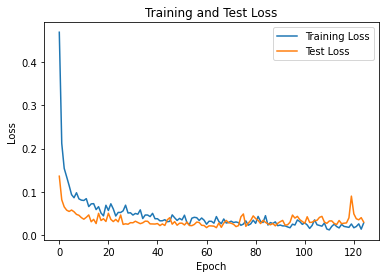

<Figure size 432x288 with 0 Axes>

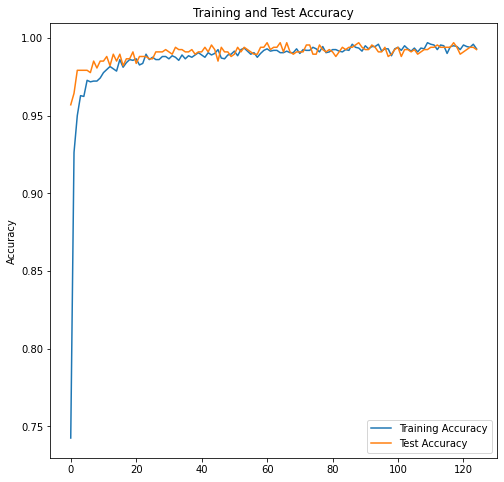

<Figure size 432x288 with 0 Axes>

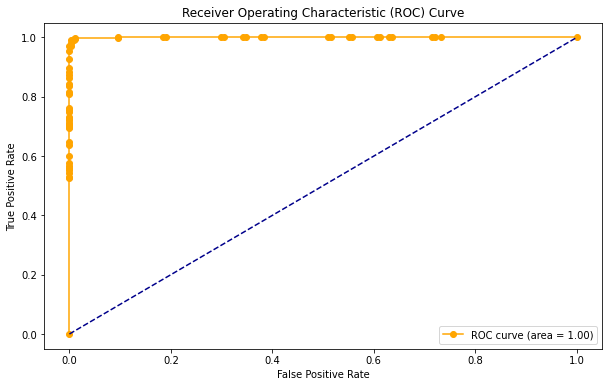

<Figure size 432x288 with 0 Axes>

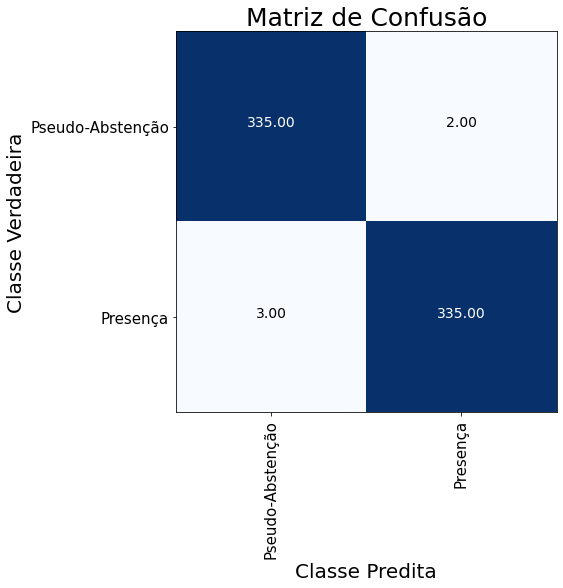

TRAIN: [   0    1    2 ... 2695 2696 2697] TEST: [ 654  656  657  664  665  666  667  672  674  676  678  680  682  683
  684  685  686  688  691  692  695  696  697  698  699  700  701  702
  703  704  705  706  707  708  709  710  711  712  713  714  715  716
  717  718  719  720  721  722  723  724  725  726  727  728  729  730
  731  732  733  734  735  736  737  738  739  740  741  742  743  744
  745  746  747  748  749  750  751  752  753  754  755  756  757  758
  759  760  761  762  763  764  765  766  767  768  769  770  771  772
  773  774  775  776  777  778  779  780  781  782  783  784  785  786
  787  788  789  790  791  792  793  794  795  796  797  798  799  800
  801  802  803  804  805  806  807  808  809  810  811  812  813  814
  815  816  817  818  819  820  821  822  823  824  825  826  827  828
  829  830  831  832  833  834  835  836  837  838  839  840  841  842
  843  844  845  846  847  848  849  850  851  852  853  854  855  856
  857  858  859  860  861  8

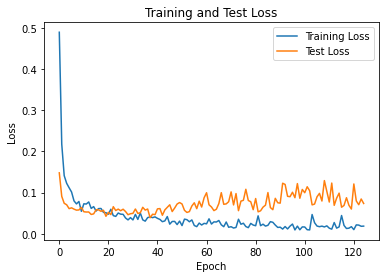

<Figure size 432x288 with 0 Axes>

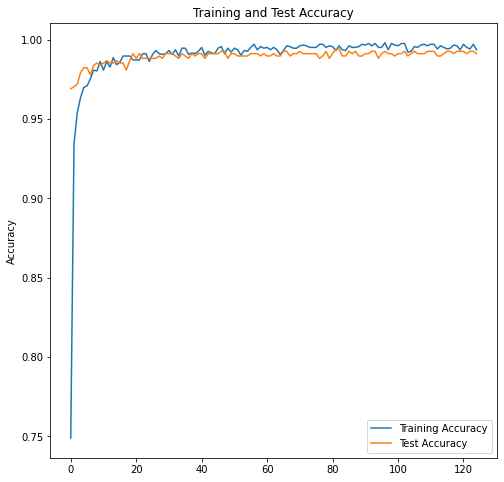

<Figure size 432x288 with 0 Axes>

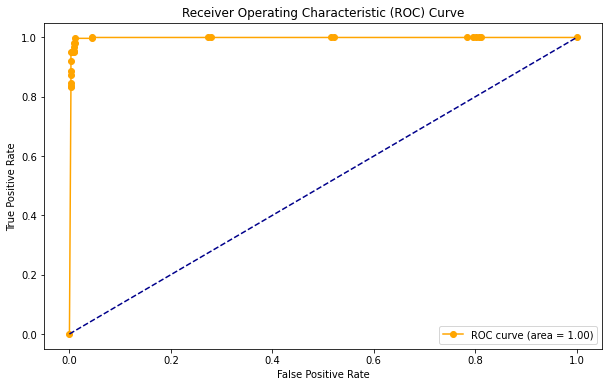

<Figure size 432x288 with 0 Axes>

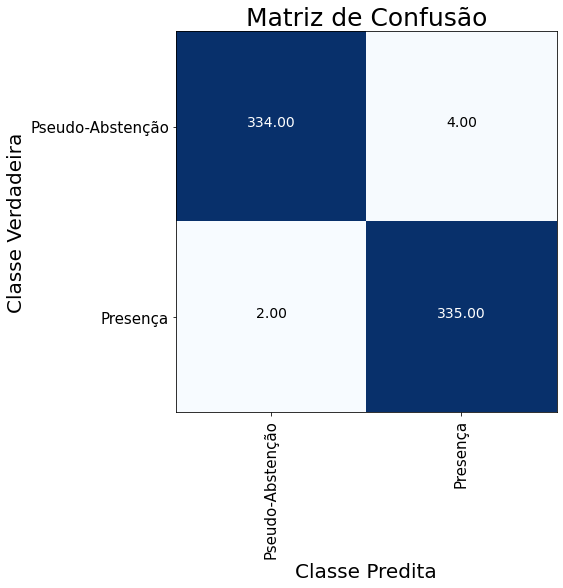

TRAIN: [   0    1    2 ... 2695 2696 2697] TEST: [1334 1337 1338 1339 1342 1344 1351 1353 1358 1359 1360 1361 1362 1363
 1364 1365 1366 1367 1368 1369 1370 1371 1372 1373 1374 1375 1376 1377
 1378 1379 1380 1381 1382 1383 1384 1385 1386 1387 1388 1389 1390 1391
 1392 1393 1394 1395 1396 1397 1398 1399 1400 1401 1402 1403 1404 1405
 1406 1407 1408 1409 1410 1411 1412 1413 1414 1415 1416 1417 1418 1419
 1420 1421 1422 1423 1424 1425 1426 1427 1428 1429 1430 1431 1432 1433
 1434 1435 1436 1437 1438 1439 1440 1441 1442 1443 1444 1445 1446 1447
 1448 1449 1450 1451 1452 1453 1454 1455 1456 1457 1458 1459 1460 1461
 1462 1463 1464 1465 1466 1467 1468 1469 1470 1471 1472 1473 1474 1475
 1476 1477 1478 1479 1480 1481 1482 1483 1484 1485 1486 1487 1488 1489
 1490 1491 1492 1493 1494 1495 1496 1497 1498 1499 1500 1501 1502 1503
 1504 1505 1506 1507 1508 1509 1510 1511 1512 1513 1514 1515 1516 1517
 1518 1519 1520 1521 1522 1523 1524 1525 1526 1527 1528 1529 1530 1531
 1532 1533 1534 1535 1536 15

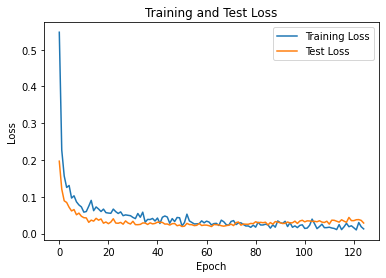

<Figure size 432x288 with 0 Axes>

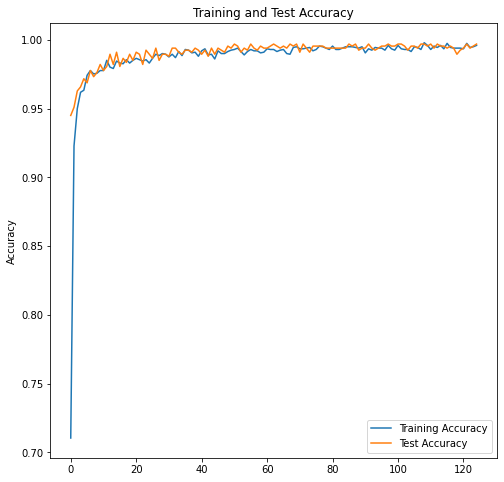

<Figure size 432x288 with 0 Axes>

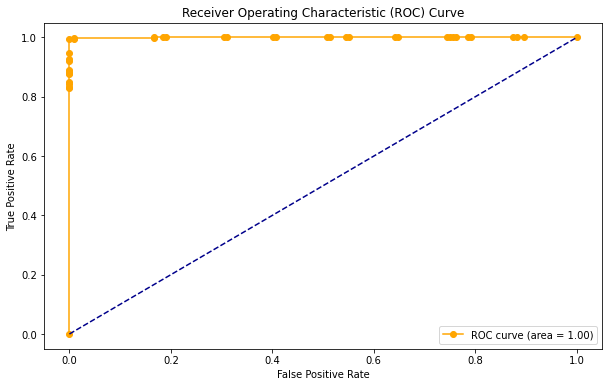

<Figure size 432x288 with 0 Axes>

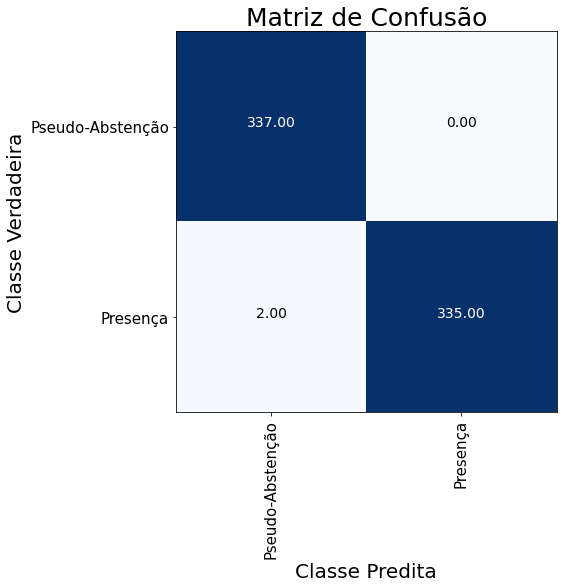

TRAIN: [   0    1    2 ... 2021 2022 2023] TEST: [2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037
 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051
 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065
 2066 2067 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079
 2080 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091 2092 2093
 2094 2095 2096 2097 2098 2099 2100 2101 2102 2103 2104 2105 2106 2107
 2108 2109 2110 2111 2112 2113 2114 2115 2116 2117 2118 2119 2120 2121
 2122 2123 2124 2125 2126 2127 2128 2129 2130 2131 2132 2133 2134 2135
 2136 2137 2138 2139 2140 2141 2142 2143 2144 2145 2146 2147 2148 2149
 2150 2151 2152 2153 2154 2155 2156 2157 2158 2159 2160 2161 2162 2163
 2164 2165 2166 2167 2168 2169 2170 2171 2172 2173 2174 2175 2176 2177
 2178 2179 2180 2181 2182 2183 2184 2185 2186 2187 2188 2189 2190 2191
 2192 2193 2194 2195 2196 2197 2198 2199 2200 2201 2202 2203 2204 2205
 2206 2207 2208 2209 2210 22

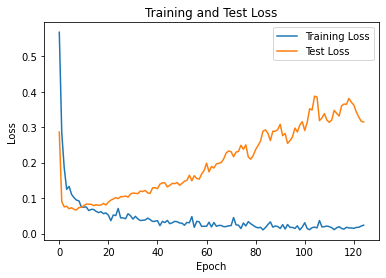

<Figure size 432x288 with 0 Axes>

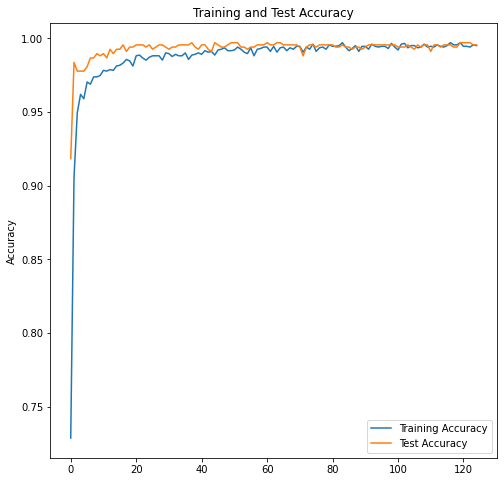

<Figure size 432x288 with 0 Axes>

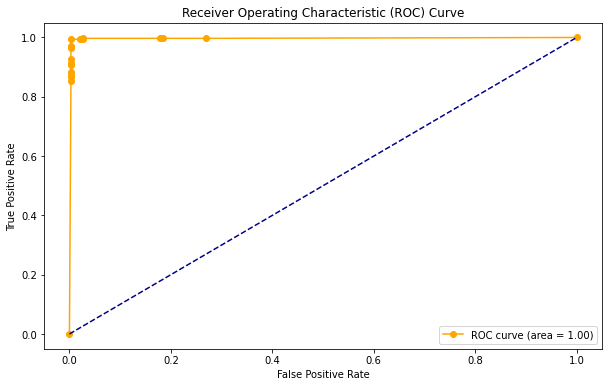

<Figure size 432x288 with 0 Axes>

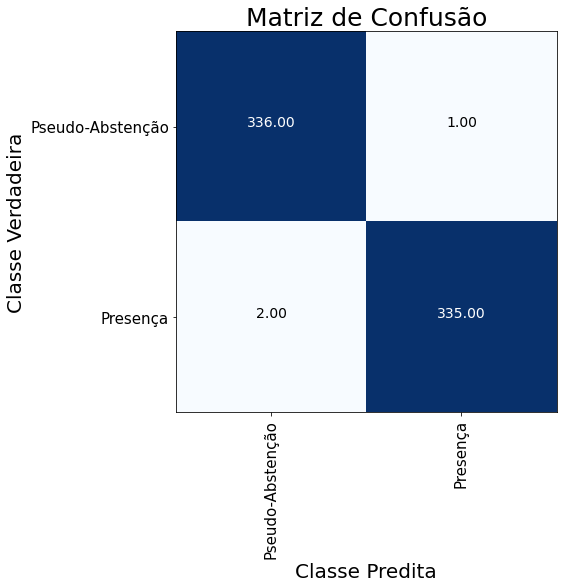

<Figure size 432x288 with 0 Axes>

In [16]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics.ranking import precision_recall_curve, roc_auc_score, roc_curve
from sklearn.utils.class_weight import compute_class_weight
import collections
import numpy as np

try:
    import keras
    import numpy as np
    import matplotlib.pyplot as plt
    from imblearn.keras import balanced_batch_generator
    from imblearn.under_sampling import NearMiss
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Activation, Flatten
    from keras.optimizers import Adam
    from keras.losses import categorical_crossentropy
    from keras import regularizers
    from tensorflow.keras.optimizers import SGD

except:
    print("Keras not found")


species_weights_folder = f"{model_weights_folder_path}/{species_name_string}/{strategy}"
utils_methods.create_folder_structure(species_weights_folder)

test_acc_list = []
test_auc_list = []

complete_model_scaled_df_shuffled = complete_model_scaled_df.sample(frac=1)
X = complete_model_scaled_df_shuffled.loc[:, complete_model_scaled_df_shuffled.columns != 'presence/pseudo_absence'].to_numpy()
y = complete_model_scaled_df_shuffled.loc[:, complete_model_scaled_df_shuffled.columns == 'presence/pseudo_absence'].to_numpy()
skf = StratifiedKFold(n_splits=4)
for i,(train_index, test_index) in enumerate(skf.split(X, y)):
  print("TRAIN:", train_index, "TEST:", test_index)
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  
  class_weights = compute_class_weight('balanced', np.unique(y_train), y_train.ravel())
  train_class_weights = dict(enumerate(class_weights))

  ####################################
  #      Training and testing        #
  ####################################
  
  # prepare metrics
  test_loss=[]
  test_acc=[]
  test_AUC=[]
  test_tpr=[]
  test_uci=[]
  test_lci=[]

  Best_model_AUC=[0]

  num_inputs = X.shape[1]  # number of features

  model = Sequential()
  layer_1 = Dense(50, activation='relu',input_shape=(num_inputs,))#, kernel_regularizer=regularizers.l1(0.000001))
  layer_2 = Dense(25, activation='relu')#, kernel_regularizer=regularizers.l1(0.000001))
  layer_3 = Dense(25, activation='relu')#, kernel_regularizer=regularizers.l1(0.0000001))
  layer_4 = Dense(25, activation='relu')#, kernel_regularizer=regularizers.l1(0.00000001))
  model.add(layer_1)
  model.add(Dropout(0.3))
  model.add(layer_2)
  model.add(Dropout(0.5))
  model.add(layer_3)
  model.add(Dropout(0.3))
  model.add(layer_4)
  model.add(Dropout(0.5))
  model.add(Dense(1,activation='sigmoid'))

  model.compile(optimizer='adam', 
                loss='binary_crossentropy', 
                metrics=['accuracy','AUC'])
  

  H = model.fit(X_train, 
                y_train.ravel(), 
                validation_data=(X_test, y_test.ravel()),
                batch_size=batch_size,
                epochs=epochs,
                class_weight = train_class_weights,
                verbose=0)

  #Calculating History
  H.history.keys()
  # plot_loss_accuracy_epoch(H)
  train_acc = H.history['accuracy']
  train_loss = H.history['loss']
  test_acc = H.history['val_accuracy']
  test_loss = H.history['val_loss']

  #Calculating Scores
  score = model.evaluate(X_test,y_test,verbose=1)
  print('Valid loss:', score[0])
  print('Valid acc:', score[1])
  test_acc_list.append(score[1])
  
  #Creting Species Results Folder
  baseline_kfold_result_folder = f"{project_root}/Results/{species_name}/{strategy}/Kfold{i+1}"
  utils_methods.create_folder_structure(baseline_kfold_result_folder)

  #PLotting and Saving LOSS and ACC 
  plot_and_save_loss(train_loss,test_loss,os.path.join(baseline_kfold_result_folder,"Losses"))
  plot_and_save_acc(train_acc,test_acc,os.path.join(baseline_kfold_result_folder,"Accuracy"))
  
  # Plot and Saving ROC Curve and Confusion Metrics
  yhat = model.predict(X_test)
  y_pred = (yhat> 0.5).astype('int32')
  yhat = yhat[:, 0] # manter somente para a classe positiva
  AUC = plot_roc_curve(y_test, yhat,os.path.join(baseline_kfold_result_folder,"ROC_AUC"),figsize=(10,6))
  test_auc_list.append(AUC)
  plot_confusion_matrix(y_true=y_test, y_pred=y_pred, classes=["Pseudo-Abstenção","Presença"], output_path = os.path.join(baseline_kfold_result_folder,"Confusion_Matrix"))

  #Saving Model Weights for the best AUC result
  if AUC > Best_model_AUC[0]:
      # if yes save model to disk / overwrite previous model
      Best_model_AUC[0]=AUC
      model_json=model.to_json()
      with open (f'{species_weights_folder}/{species_name_string}_model.json','w') as json_file:
          json_file.write(model_json)
      model.save_weights(f'{species_weights_folder}/{species_name_string}_model.h5')

In [17]:
print(f"Best acuraccy results in each Kfold \n{test_acc_list}")
print(f"Best AUC results in each Kfold \n{test_auc_list}")

Best acuraccy results in each Kfold 
[0.9925925731658936, 0.9911110997200012, 0.997032642364502, 0.9955489635467529]
Best AUC results in each Kfold 
[0.9995961582357382, 0.9978359348936843, 0.9994804920356788, 0.9963502364201499]
